In [1]:
import pandas as pd

In [2]:
# NSMC 데이터

train = pd.read_table('nsmc_ratings_train.txt')
test = pd.read_table('nsmc_ratings_test.txt')

In [3]:
# 기본 정보
print(train.shape, test.shape)
print(train.isna().sum())       # 결측치 확인
print(train.head(3))

(150000, 3) (50000, 3)
id          0
document    5
label       0
dtype: int64
         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0


## 함수 basic_clean

### df = df.copy()
- 원본을 건드리지 않고 안전하게 복사본에서 작업
- 판다스의 SettingWithCopyWarning(체인 인덱싱 경고)나 원본 데이터 오염 방지

### df['document'] = df['document'].astype(str).str.strip()
- document 컬럼을 전부 문자열로 변환함
- 좌우 공백 제거 (스페이스, 탭, 줄바꿈 등 일반 공백)
- 주의할 점
    - NaN이 'nan' 문자열로 바뀌는 문제
        - 다음 단계에서 길이가 2이므로 빈 문자열 제거로는 걸러지지 않음 = 결측치가 살아남음
        - 해결은 결측치 먼저 제거

### df = df[df['document'].str.len() > 0]
- 빈 문자열인 행 제거
- 한계
    - 공백만 있는 문자열은 stip()으로 이미 빈 문자열이 되었으니 이 단계에서 제거됨
    - 하지만 유니코드 '제로폭 공백'은 남을 수 있음 -> 정규식으로 별도 제거가 필요할 수 있음

### df = df.drop_duplicates(subset=["document"])
- 완전히 동일한 문장을 가진 중복 샘플 제거
- 데이터 누수와 편향 완화, 학습의 중복 정보 감소

### df = df[df["document"].str.len() >= 2]
- 너무 짧은 텍스트 제거
- ㅋ, ㅎ, ㅠ 같이 한 글자만 있는 경우는 모델에 노이즈가 되기 쉽기 때문
- 감성 분석에서는 의미 있는 감정 표현을 너무 적극적으로 지우면 성능이 떨어질 수 있음 -> 최소 길이를 2로 잡아서 절충

In [4]:
def basic_clean(df):
    df = df.copy()

    #1. 결측치, 공백 제거
    df['document'] = df['document'].astype(str).str.strip()
    df = df[df['document'].str.len() > 0]

    # 2. 중복 제거
    df = df.drop_duplicates(subset=['document'])

    # 3. 너무 짧은 텍스트 제거 (길이 2 미만)
    df = df[df['document'].str.len() >= 2]
    return df

In [5]:
train = basic_clean(train)
test  = basic_clean(test)
print(train.shape, test.shape)

(146082, 3) (49098, 3)


## 한국어 친화 정규화

- URL/이메일/숫자/전화번호 → 토큰 치환 (\<URL>, \<EMAIL>, \<NUM>, \<PHONE>)

- HTML 제거

- 유니코드 표준화(NFKC): 전각/반각, 호환 글자 정규화

- 반복 문자 압축: ㅋㅋㅋㅋ → ㅋㅋ, !!!! → !!, ㅠㅠㅠ → ㅠㅠ

- 부정 결합(선택): 안 하다/못 하다 → 안하다/못하다 (부정 의미 보존)

- 허용 문자 이외는 공백으로 치환 후 다중 공백을 1칸으로

In [6]:
import re, unicodedata

RE_HTML  = re.compile(r"<.*?>") #HTML 태그 제거
RE_URL   = re.compile(r"(https?://\S+|www\.\S+)") #URL 감지
RE_EMAIL = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}") # 이메일 감지
RE_PHONE = re.compile(r"(?:\+?\d{1,3}[-.\s]?)?(?:\d{2,4}[-.\s]?){2,3}\d{3,4}") # 전화번호 감지
RE_NUM   = re.compile(r"\b\d+(?:[,.]\d+)?\b") # 숫자 감지

# ㅋㅋㅋ, ㅎㅎㅎ, ㅠㅠㅠ, ㅜㅜㅜ, !!!, ??, ~~ 등을 2개로 압축
RE_REPEAT_FEEL = re.compile(r"([ㅋㅎㅠㅜ!?~])\1{1,}", flags=re.UNICODE) # 반복 감정표현 감지

#### 1. 정규화 함수 (정규식 활용)

In [7]:
import re, unicodedata

ALLOWED_CHARS = re.compile(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9<>\s\.\,\!\?\:\;\'\"\-\_\(\)]") # 이모지, 특수문자, 외국어 기호 날리기

def _compress_feel(s: str) -> str: # def 함수 이름(매개변수:타입) -> 반환타입:
    return RE_REPEAT_FEEL.sub(lambda m:m.group(1)*2, s) #
#이 정규식은 "ㅋㅋㅋㅋ", "ㅎㅎㅎ", "ㅠㅠㅠㅠ", "!!!", "~~~" 같은 같은 문자의 반복을 찾음

#([ㅋㅎㅠㅜ!?~]) → 반복되는 문자 하나 (m.group(1))

#\1{1,} → 그 문자가 최소 1번 이상 반복

#RE_REPEAT_FEEL.sub(lambda m: m.group(1)*2, s)
#👉 "반복이 몇 번이든 무조건 2개만 남기기"

In [8]:
# 매우 보수적인 부정 결합: '안 하다' → '안하다' 등
RE_NEG = re.compile(r"\b(안|못)\s+(하다|해요|해서|하면|했다|해|할|함|돼|됩니다|돼요)\b")
def _join_negation(s: str) -> str:
    return RE_NEG.sub(lambda m: m.group(1)+m.group(2), s)

# 띄어쓰기로 분리되어 있으면 별개 단어로 들어가있음
# 부정 의미라는 사실을 놓치게 됨

In [9]:
def korean_normalize(text: str, join_neg: bool = True) -> str: #join_neg=True이면 "안 하다" → "안하다" 같은 부정 결합 수행
    if not isinstance(text, str):
        return "" #문자열이 아니면 빈 문자열로 전환
    # 1) 유니코드 표준화
    text = unicodedata.normalize("NFKC", text)
    # 2) HTML 제거
    text = RE_HTML.sub(" ", text)
    # 3) URL/EMAIL/PHONE 치환 (숫자보다 먼저)
    text = RE_URL.sub(" <URL> ", text)
    text = RE_EMAIL.sub(" <EMAIL> ", text)
    text = RE_PHONE.sub(" <PHONE> ", text)
    # 4) 숫자 치환
    text = RE_NUM.sub(" <NUM> ", text)
    # 5) 감정표현 반복 축약
    text = _compress_feel(text)
    # 6) (선택) 부정 결합
    if join_neg:
        text = _join_negation(text)
    # 7) 허용 문자 외 공백 치환 → 다중 공백 축소
    text = ALLOWED_CHARS.sub(" ", text)
    text = re.sub(r"\s{2,}", " ", text).strip()
    return text

In [10]:
# 적용 함수 (전처리 이후 추가 필터)
def apply_normalize(df, col="document", join_neg=True, min_len=2):
    df = df.copy() #전처리할 데이터프레임
    # 만약 이전 단계에서 'nan' 문자열이 살아있다면 제거
    df = df[df[col].astype(str).str.lower() != "nan"]
    df[col] = df[col].apply(lambda x: korean_normalize(x, join_neg=join_neg))
    df = df[df[col].str.len() >= min_len]
    return df


#### 2. 정규화 실행

In [11]:
train_norm = apply_normalize(train, col="document", join_neg=True)
test_norm = apply_normalize(test, col="document", join_neg=True)
print("After normalize:", train_norm.shape, test_norm.shape)
print(train_norm.head(3))

After normalize: (145891, 3) (49008, 3)
         id                           document  label
0   9976970                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                  너무재밓었다그래서보는것을추천한다      0


#### 3. 토큰화 + 불용어 제거

In [12]:
import re

In [13]:
# 간단 불용어 예시(필요시 확장)
stopwords = set("""
이 그 저 데 을 를 은 는 이 가 에 의 와 과 도 으로 로 에서 까지 보다 보다도 그리고 그러나 하지만
한다 했다 하다 해요 해서 하면 했고 할 할까 랑 와요 네요 요 는군 다가 라도 라서 면서 라니
""".split())

In [14]:
# 백업 토크나이저: 공백 분리 후, 허용 패턴 토큰만 남김
TOKEN_RE = re.compile(r"[가-힣A-Za-z0-9<>]+") #허용 패턴 토큰
def simple_tokenize(text: str):
    return [t for t in TOKEN_RE.findall(text)]

In [15]:
# 가능한 경우 Okt 사용
try:
    from konlpy.tag import Okt
    okt = Okt() # konlpy 라이브러리 안의 Okt 형태소 분석기 불러옴
    def tokenize_ko(text: str):
        # 형태소 단위 토큰화 + 불용어 제거
        # 문장을 형태소 단위로 나눔, stem=True면 동사/형용사를 기본형으로 변환
        toks = okt.morphs(text, stem=True)  # 어간추출 (선호에 따라 False)
        # 불용어제거 + 너무 짧은 토큰 제거
        return [t for t in toks if t not in stopwords and len(t) > 1 or t.startswith("<")] # 특수 토큰 유지
    print("Using KoNLPy Okt tokenizer.") #Okt 사용가능하다는 메세지 출력
except Exception as e:
    def tokenize_ko(text: str):
        toks = simple_tokenize(text)
        return [t for t in toks if t not in stopwords and (len(t) > 1 or t.startswith("<"))]
    print("Falling back to simple tokenizer.", e)

Using KoNLPy Okt tokenizer.


#### 4. TF-IDF 벡터화

- 이미 tokens 리스트가 있으므로, Vectorizer에 'identity' 토크나이저를 써서 리스트 그대로 넣음

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
# 한국어도 잡히도록 token_pattern만 약간 완화 (1글자 토큰 허용하려면 \w+)
vectorizer = TfidfVectorizer(
    token_pattern=r"(?u)\b\w+\b",   # 유니코드 단어 문자 토큰화 (한글 포함)
    ngram_range=(1,2),
    min_df=3, max_df=0.98, max_features=40000,
    lowercase=False,
    stop_words=None  # 원하면 한국어 불용어 리스트를 직접 넣을 수 있음
)

In [20]:
X_train = vectorizer.fit_transform(train_norm["document"])
X_test  = vectorizer.transform(test_norm["document"])

y_train = train_norm["label"].astype(int)
y_test  = test_norm["label"].astype(int)

#### 5. 모델 학습 및 평가
- 로지스틱 회귀 (선형, 빠르고 강력한 베이스 라인)
- 나이브 베이즈(멀티노미얼) 비교
- 성능 지표 : Accuracy

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#### evaluate_model 함수
- fit : 훈련 데이터로 파라미터 (가중치) 학습
- predict : 테스트 데이터의 레이블 (0=부정, 1=긍정) 예측
- accuracy : 전체 중 맞춘 비율
- f1 : 불균형일 때 유용
- classification_report : 클래스별 precision/recall/f1, macro/weighted 평균까지
- confusion_matrix:

[[TN, FP],

 [FN, TP]]

In [22]:
def evaluate_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr) #훈련 학습
    pred = model.predict(Xte) # 예측 : 0인지 1인지
    acc = accuracy_score(yte, pred) # 정확도
    f1  = f1_score(yte, pred) # F1 = 정밀도/재현율의 조화평균
    print(f"[{name}]  Acc={acc:.4f}  F1={f1:.4f}")
    print(classification_report(yte, pred, digits=4)) # precision/recall/F1 by class
    print("Confusion:\n", confusion_matrix(yte, pred)) #혼동행렬
    return model

#### 로지스틱 회귀
- 선형 분류기 -> 각 단어에 가중치 w를 학습해서 시그모이드로 확률을 생성
- 하이퍼파라미터
    - C : 규제강도의 역수 -> 클수록 규제약함, 과적합 느낌 나면 C 줄이기
    - solver : 최적화 방법
        - liblinear : 소규모 / 희소에 안정적 (이진분류)
        - saga : 대규모 / 다중클래스
    - max_iter : 수렴할 때까지 반복 허용 횟수 -> 경고뜨면 늘리기
- 장점 : TF-IDF와 궁합이 좋고, 빠르며 해석이 쉬움
- 확률이 필요하면 logreg.predict_proba(X_test)[:,1] 로 긍정 확률 추출 가능 → 임계값 0.5 조정도 가능.

In [23]:
# 로지스틱 회귀
logreg = LogisticRegression(
    max_iter=1000,
    C=2.0,
    solver="liblinear"  # 데이터/특징 따라 'saga'도 가능
)

In [24]:
logreg = evaluate_model("LogReg", logreg, X_train, y_train, X_test, y_test)


[LogReg]  Acc=0.8167  F1=0.8106
              precision    recall  f1-score   support

           0     0.7935    0.8536    0.8224     24370
           1     0.8435    0.7802    0.8106     24638

    accuracy                         0.8167     49008
   macro avg     0.8185    0.8169    0.8165     49008
weighted avg     0.8186    0.8167    0.8165     49008

Confusion:
 [[20803  3567]
 [ 5415 19223]]


#### 멀티노미얼 나이브 베이즈
- 단어 발생 분포 가정 (조건부 독립 가정) 기반의 고전 텍스트 분류기
- 하이퍼파라미터
    - alpha : 라플라스/리질레이스 평활화 -> 작으면 데이터에 민감함 (0.1~1 사이 탐색 추천)
- 특징 : Count 기반에 특히 잘 맞고 TF-IDF도 자주 사용함

In [25]:
# 나이브 베이즈
nb = MultinomialNB(alpha=0.5)
nb = evaluate_model("MultinomialNB", nb, X_train, y_train, X_test, y_test)

[MultinomialNB]  Acc=0.8216  F1=0.8159
              precision    recall  f1-score   support

           0     0.7986    0.8576    0.8271     24370
           1     0.8481    0.7861    0.8159     24638

    accuracy                         0.8216     49008
   macro avg     0.8233    0.8218    0.8215     49008
weighted avg     0.8235    0.8216    0.8214     49008

Confusion:
 [[20900  3470]
 [ 5271 19367]]


#### 6. 해석

####  가중치로 상위 특징 확인 (로지스틱 회귀 기준)

- 각 피처에 대해서 가중치가 있어서 이걸 양수와 음수 기준으로 정렬하면 긍정에 기여하는 단어와 부정에 기여하는 단어를 직접 뽑을 수 있음

In [26]:
import numpy as np

In [31]:
# TfidVectorizer가 만든 단어 (ngram)리스트를 가져옴
feat_names = np.array(vectorizer.get_feature_names_out())
# 로지스틱 회귀는 각 단어마다 가중치 학습
coefs = logreg.coef_[0]

In [32]:
feat_names

array(['0', '007시리즈', '007을', ..., '힘입어', '힛걸', '힝'],
      shape=(40000,), dtype=object)

In [33]:
coefs

array([ 0.77835242,  0.01245015, -0.10333297, ..., -0.76420947,
        1.27581431, -0.56253127], shape=(40000,))

In [28]:
top_pos_idx = np.argsort(coefs)[-20:][::-1]  # 긍정 가중치 큰 토큰
top_neg_idx = np.argsort(coefs)[:20]         # 부정 가중치 큰 토큰

In [29]:
print("[Top positive tokens]")
for i in top_pos_idx:
    print(f"{feat_names[i]:<20s} {coefs[i]:.4f}")


[Top positive tokens]
여운이                  6.9164
최고의                  6.3412
최고다                  6.3281
최고                   6.1974
수작                   5.7928
재밌음                  5.5921
명작                   5.3797
재밌다                  5.3625
좋고                   5.3490
재미있어요                5.1519
가슴이                  5.1178
좋았어요                 5.0849
재밌어요                 5.0768
재밌네요                 5.0390
짱                    4.9794
굿                    4.8958
감동                   4.8727
꿀잼                   4.8460
10점준다                4.8142
명작이다                 4.6974


In [30]:
print("\n[Top negative tokens]")
for i in top_neg_idx:
    print(f"{feat_names[i]:<20s} {coefs[i]:.4f}")


[Top negative tokens]
최악의                  -9.3668
최악                   -7.8625
아깝다                  -7.1537
졸작                   -6.5341
쓰레기                  -6.4617
차라리                  -6.4269
쓰레기영화                -6.2812
지루하다                 -6.2383
재미없다                 -6.0430
최악이다                 -5.9565
1점도                  -5.8677
지루함                  -5.3797
노잼                   -5.3707
별로                   -5.3665
지루하고                 -5.2770
재미없는                 -5.1388
별로다                  -4.9514
망작                   -4.9459
재미없어                 -4.8964
실망                   -4.8139


#### 가중치로 상위 특징 확인 (나이브 베이즈 기준)
- 로지스틱처럼 계수 벡터를 갖는건 아니지만 각 클래스별 단어 조건부 확률을 가지고 있음
- 모델 내부 변수:
    - nb.feature_log_prob -> shape = (클래스 개수, 단어 개수)
    - 각 행이 클래스, 각 열이 단어
    - 값은 로그 확률 log P(word | class)

In [34]:
import numpy as np

# 피처 이름 (단어 리스트)
feat_names = np.array(vectorizer.get_feature_names_out())

# 각 클래스별 log 확률
log_prob = nb.feature_log_prob_

In [38]:
# 긍정 클래스(1) 상위 20개 단어
top_pos_idx = np.argsort(log_prob[1])[-20:][::-1]
print("[Top positive tokens - NB]")
for i in top_pos_idx:
    print(f"{feat_names[i]:<20s} {log_prob[1][i]:.4f}")

[Top positive tokens - NB]
영화                   -4.8272
정말                   -5.1849
너무                   -5.4522
진짜                   -5.5811
최고의                  -5.8783
이                    -5.9120
최고                   -5.9481
잘                    -6.1718
역시                   -6.2142
더                    -6.2639
수                    -6.3077
드라마                  -6.3211
보고                   -6.3257
NUM                  -6.4087
재밌게                  -6.4176
완전                   -6.4517
이런                   -6.4570
좋은                   -6.4609
본                    -6.4638
다시                   -6.4773


In [39]:
# 부정 클래스(0) 상위 20개 단어
top_neg_idx = np.argsort(log_prob[0])[-20:][::-1]
print("\n[Top negative tokens - NB]")
for i in top_neg_idx:
    print(f"{feat_names[i]:<20s} {log_prob[0][i]:.4f}")


[Top negative tokens - NB]
영화                   -4.9539
너무                   -5.5298
진짜                   -5.5433
그냥                   -5.6839
정말                   -5.8427
왜                    -5.8605
이                    -6.0394
NUM                  -6.0734
이런                   -6.0762
쓰레기                  -6.0885
이건                   -6.1143
이게                   -6.1704
좀                    -6.1804
아                    -6.1830
아깝다                  -6.2753
없다                   -6.2839
다                    -6.3090
영화는                  -6.3790
더                    -6.3954
이거                   -6.4191


# 왜 로지스틱이 더 잘 맞을까?

## 1. 가정의 차이

#### 나이브 베이즈
- 모든 단어가 조건부 독립이라고 가정함
- 즉, '너무'와 '재밌다'가 같이 나오든, '진짜'와 '최악'이 같이 나오든 상관없이 단어 확률을 곱함
- 현실의 언어는 단어들이 강하게 의존적이라서 이 가정이 자주 깨짐 -> 성능의 한계

#### 로지스틱 회귀
- 독립 가정을 두지 않고 단어별로 가중치를 학습함
- '너무'가 '재밌다'랑 같이 나왔을 때 긍정으로 기울어지도록, '재밌다'에 강한 양수 계수, '최악'에는 강한 음수 계수를 줌 -> 더 유연하고 현실에 잘 맞음

## 2. TF-IDF와의 궁합

- 나이브 베이즈는 원래 단어 count에 더 잘 맞음 (단순하게 단어가 몇 번 나왔는지)
- TF-IDF처럼 가중치가 들어간 피처에서는 나이브 베이즈의 수학적 가정이 깨져서 성능이 떨어질 수 있음
- 로지스틱은 TF-IDF와 궁합이 좋음 (희소 행렬에 잘 작동하고, L2 정규화로 과적합 방지)


## 3. 해석가능성
- 로지스틱은 coef_로 "긍정/부정에 얼마나 기여했는지"를 직관적으로 해석할 수 있음
- 나이브 베이즈는 확률 분포 기반이라 "이 클래스에서 많이 나오는 단어"정도밖에 안 보여줌
- 인사이트를 뽑기에도 로지스틱이 유리함

# TF-IDF

### 1) 정의
- 문서에서 중요한 단어에 더 큰 가중치를 주는 표현 방식
- TF : 문서 안에서 많이 나온 단어일수록 중요성 증가
- IDF : 여러 문서에 널리 퍼진 공통 단어는 정보력 하락 = 가중치 하락
- 자주 나오지만 모든 문서에서 흔하지 않은 단어가 큰 값을 받음

### 2) 기본 수식

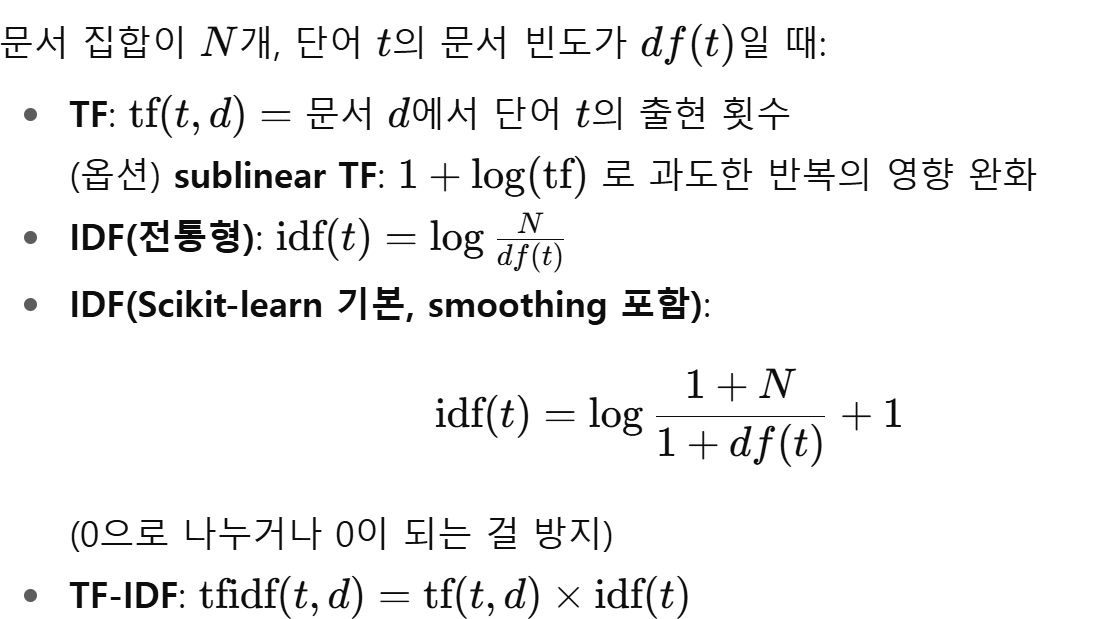

- 보통 문서 벡터 단위 L2정규화를 함 -> 각 문서 벡터 길이를 1로 맞춤
- 이렇게 하면 문서 길이 차이 (짧은 /긴 리뷰)에 덜 민감해지고 , 코사인 유사도/선형 모델에 잘 맞음

### 3) 손계산 미니 예시 (자연로그 기준)

#### 작은 코퍼스 3문서
- D1 : "영화 최고"
- D2 : "영화 별로"
- D3 : "최고 최고 영화"
- 단어 : 영화, 최고 , 별로
- 문서수 N = 3

#### 문서 빈도 df:
- df(영화) = 3 (세 문서 모두)
- df(최고) = 2 (D1, D3)
- df(별로) = 1 (D2)

#### IDF (스무딩 사용)
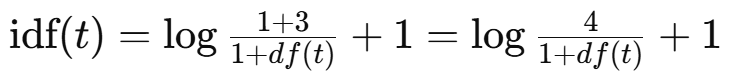
- 영화 : log(4/4) + 1 = log1 + 1 = 1.00
- 최고 : log(4/3) + 1 = 1.288
- 별로 : log(4/2) + 1 = 1.693

#### TF
- D1 : 영화 1, 최고 1
- D2 : 영화 1, 별로 1
- D3 : 영화 1, 최고 2

#### TF-IDF (정규화 전)
- D1 : [영화 1.000, 최고 .1288, 별로 0]
- D2 : [영화 1.000, 최고 0, 별로 1.693]
- D3 : [영화 1.000, 최고 2*1.288, 별로 0]

#### L2 정규화 (각 문서 벡터 길이로 나눔 = 근삿값)
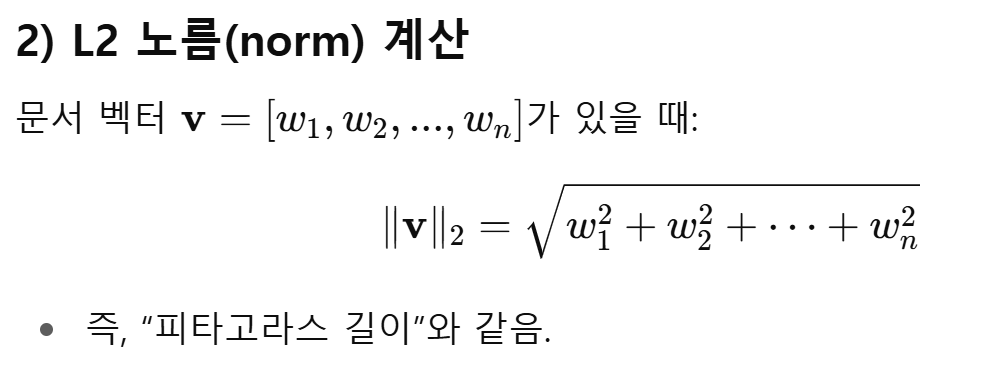

> 문서별 실제 계산 : 각 단어 값 / norm
- D1 벡터 norm = 약 1.632 -> [영화 0.613, 최고 0.79]
- D2 벡터 norm = 약 1.967 -> [영화 0.509, 별로 0.861]
- D3 벡터 norm = 약 2.763 -> [영화 0.362, 별로 0.932]

해석
- "영화"는 모든 문서에 흔해서 IDF가 1로 낮음 -> 가중치가 작음
- "별로"는 한 문서에서만 등장함 ->IDF가 크고 D2에서 비중이 큼
- "최고"는 두 문서에서 등장하지만 반복과 IDF 덕에 D3에서 비중이 큼
- 정규화 덕분에 긴 문서가 무조건 유리해지지 않음